In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 10

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "Drug",
            'fairness_agg': 'mean',
            # 'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 3,
            'epochs_per_task': 25,
            'per_task_examples': np.inf,
            # 'per_task_examples': 10000,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 5.,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.01,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:6' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.01,
            'lambda': .1,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=Drug/seed=10_epoch=25_lr=0.01_alpha=0.01_tau=5.0


In [2]:
from datasets import MNIST
from datasets import FashionMNIST
from datasets import CIFAR10, CIFAR100
from datasets.drug import Drug

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'CIFAR10':
    benchmark = CIFAR10(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'CIFAR100':        
    benchmark = CIFAR100(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'Drug':        
    benchmark = Drug(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        joint = params['random_class_idx'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (12)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



In [3]:
from algorithms.imbalance import Heuristic2
from metrics import FairMetricCollector
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = Heuristic2(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = FairMetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])


In [4]:
# from trainers import ContinualTrainer
from trainers.fair_trainer import FairContinualTrainer2 as ContinualTrainer
# from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


In [5]:
if params['fairness_agg'] == "mean":
    agg = np.mean
elif params['fairness_agg'] == "max":
    agg = np.max
else:
    raise NotImplementedError

fairness_metrics = ["std", "EER", "EO", "DP"]
for metric in metric_manager_callback.meters:
    if metric in fairness_metrics:
        metric_manager_callback.meters[metric].agg = agg


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.5, 'loss': 0.006853951708130215, 'EO': [0.0, 0.0], 'DP': -1, 'accuracy_s0': 0.5, 'accuracy_s1': 0.5, 'classwise_accuracy': {0: array([128, 128]), 1: array([ 0, 56])}, 'DP_ingredients': {'class_pred_count_s0': {0: 56}, 'class_pred_count_s1': {0: 128}, 'class_pred_count': {0: 184}, 'count_s0': 56, 'count_s1': 128, 'count': 184}}
[2] Eval metrics for task 1 >> {'accuracy': 0.5, 'loss': 0.004195051996604256, 'EO': [0.0, 0.0], 'DP': -1, 'accuracy_s0': 0.5, 'accuracy_s1': 0.5, 'classwise_accuracy': {0: array([128, 128]), 1: array([ 0, 56])}, 'DP_ingredients': {'class_pred_count_s0': {0: 56}, 'class_pred_count_s1': {0: 128}, 'class_pred_count': {0: 184}, 'count_s0': 56, 'count_s1': 128, 'count': 184}}
[3] Eval metrics for task 1 >> {'accuracy': 0.5, 'loss': 0.0034643771207850914, 'EO': [0.0, 0.0], 'DP': -1, 'accuracy_s0': 0.5, 'accuracy_s1': 0.5, 'classwise_accuracy': {1: array([ 0, 56]),

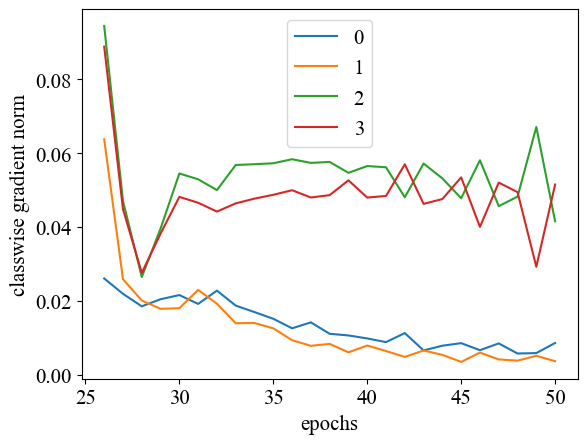

---------------------------- Task 3 -----------------------
losses=tensor([[0.0310, 0.0387, 1.1118, 1.0901, 9.0911, 9.0879]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time:0.247
Fairness:[ 0.56152409  0.56023806  0.38110599  0.38448123 -0.94437962 -0.94296966]
Current class expected loss:[ 0.          0.          0.          0.         -0.45331362 -0.45289068]
len(updated_seq_indices)=566
[51] Eval metrics for task 1 >> {'accuracy': 0.31863839285714285, 'loss': 0.0118423026541005, 'EO': [0.03163265306122451, 0.015384615384615385], 'DP': -1, 'accuracy_s0': 0.33461538461538465, 'accuracy_s1': 0.3183673469387755, 'classwise_accuracy': {0: array([ 45, 128]), 1: array([16, 56])}, 'DP_ingredients': {'class_pred_count_s0': {1: 14, 3: 4, 2: 19, 0: 19}, 'class_pred_count_s1': {2: 42, 0: 43, 1: 35, 3: 8}, 'class_pred_count': {2: 61, 0: 62, 1: 49, 3: 12}, 'count_s0': 56, 'count_s1': 128, 'count': 184}}
[51] Eval metrics for task 2 >> {'accuracy': 0.35146966854283923, 'loss'

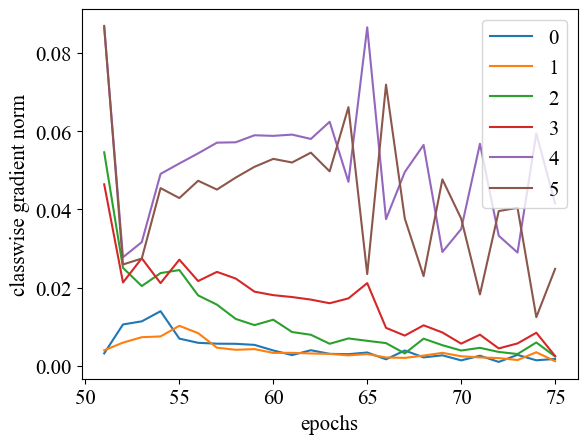

final avg-acc 0.28173458695091336
final avg-forget 0.2828785638903779


In [6]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [7]:
metric_manager_callback.meters['accuracy'].get_data()

array([[0.544, 0.   , 0.   ],
       [0.359, 0.412, 0.   ],
       [0.261, 0.129, 0.455]])

In [8]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

0.40380561736476883

In [9]:
[np.round(x, 3) for x in metric_manager_callback.meters['EO'].compute_overall()]

[0.027, 0.061, 0.021]

In [10]:
np.mean(metric_manager_callback.meters['EO'].compute_overall())

0.036228383862867766

In [11]:
[np.round(x, 3) for x in metric_manager_callback.meters['DP'].compute_overall()]

[0.031, 0.061, 0.048]

In [12]:
np.mean(metric_manager_callback.meters['DP'].compute_overall())

0.04667993883033487